In [6]:
# -*- coding: utf-8 -*-
# EDA → Preprocess for Wildfire (SQLite → CSV)
# 출력:
#   - eda/ : EDA 표/그림
#   - encoders/STATE_mapping.json
#   - Fires_Processed_AUG12.csv
#
# 모델 전제(트리 계열: XGBoost/LightGBM/RandomForest):
#   - 범주형은 숫자 코드이면 추가 명시 불필요
#   - STATE만 문자열이라 라벨 매핑(JSON) 저장
#
# 컬럼 정책:
#   사용 컬럼 = [LATITUDE, LONGITUDE, DISCOVERY_DATE, DISCOVERY_TIME,
#               CONT_DATE, CONT_TIME, FIRE_SIZE, STAT_CAUSE_CODE,
#               STATE, OWNER_CODE, DISCOVERY_DOY]
#   파생 = r_km, theta_rad, FIRE_DURATION_min, FIRE_SIZE_LOG, DOY_sin, DOY_cos
#
# EDA 추가(요청 반영):
#   - 계절(분기)/월별 FIRE_SIZE 평균·분포
#   - STAT_CAUSE_CODE별 FIRE_SIZE(로그) 박스플롯
#   - STATE별 FIRE_SIZE 평균 막대그래프 (상위 N)
# 전처리 추가(요청 반영):
#   - STATE 매핑 실패(-1) 개수/비율 누적 보고 및 경고 로그

import os
import json
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# ================= 사용자 설정 =================
DB_PATH = "wildfiredata.sqlite"    # ← SQLite 경로
TABLE = "Fires"                    # ← 테이블명
OUTPUT_CSV = "Fires_Processed_AUG12.csv"
ENCODER_DIR = "encoders"
CHUNK = 100000

KEEP_COLS = [
    "LATITUDE", "LONGITUDE",
    "DISCOVERY_DATE", "DISCOVERY_TIME",
    "CONT_DATE", "CONT_TIME",
    "FIRE_SIZE",
    "STAT_CAUSE_CODE",
    "STATE",           # 문자열(2글자 주 약어) → 라벨 매핑
    "OWNER_CODE",      # 원본 코드 유지
    "DISCOVERY_DOY",
]

In [8]:
# ================= 유틸 함수들 =================
def ensure_dirs():
    os.makedirs(ENCODER_DIR, exist_ok=True)
    os.makedirs(EDA_DIR, exist_ok=True)

def sql_scalar(conn, q):
    return pd.read_sql_query(q, conn).iloc[0, 0]

def table_has_cols(conn, table, cols):
    test = pd.read_sql_query(f"SELECT * FROM {table} LIMIT 1;", conn)
    missing = [c for c in cols if c not in test.columns]
    if missing:
        raise ValueError(f"입력 테이블에 필요한 컬럼이 없습니다: {missing}")

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0088
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def to_datetime_safe(s):
    out = pd.to_datetime(s, errors="coerce")
    needs_excel = out.isna() & pd.to_numeric(s, errors="coerce").notna()
    if needs_excel.any():
        out2 = pd.to_datetime(pd.to_numeric(s, errors="coerce"),
                              errors="coerce", unit="D", origin="1899-12-30")
        out = out.where(~needs_excel, out2)
    return out

def hhmm_to_hm_series(time_series):
    s = pd.Series(time_series)
    s_str = s.astype(str).str.replace(r"\.0$", "", regex=True).str.zfill(4)
    valid = s_str.str.match(r"^\d{4}$")
    hh = pd.to_numeric(s_str.str[:2], errors="coerce").fillna(0).astype(int)
    mm = pd.to_numeric(s_str.str[2:], errors="coerce").fillna(0).astype(int)
    hh = np.where(valid & (hh.between(0,23)) & (mm.between(0,59)), hh, 0)
    mm = np.where(valid & (mm.between(0,59)), mm, 0)
    return pd.Series(hh), pd.Series(mm)

def combine_dt(date_series, time_series):
    date_dt = to_datetime_safe(date_series)
    hh, mm = hhmm_to_hm_series(time_series)
    return date_dt + pd.to_timedelta(hh, unit="h") + pd.to_timedelta(mm, unit="m")

def build_state_mapping(conn, table):
    df = pd.read_sql_query(f"SELECT DISTINCT STATE FROM {table};", conn)
    vals = df["STATE"].dropna().astype(str).str.strip().str.upper()
    classes = sorted(vals.unique())
    return {v: i for i, v in enumerate(classes)}  # 0부터 시작

def apply_state_mapping(series, mapping):
    s = series.astype(str).str.strip().str.upper()
    out = s.map(mapping)
    return out.fillna(-1).astype(int)  # 미등록/결측: -1


In [9]:
# ================= EDA 단계 =================

def run_eda(conn):
    print("[EDA] 시작")

    # 총 행수
    n_rows = pd.read_sql_query(f"SELECT COUNT(1) AS n FROM {TABLE};", conn)["n"].iat[0]
    print(f"총 행수: {n_rows:,}")

    # 결측률
    miss_rows = []
    for col in KEEP_COLS:
        cnt = pd.read_sql_query(f"SELECT COUNT({col}) AS c FROM {TABLE};", conn)["c"].iat[0]
        miss = n_rows - cnt
        miss_rows.append({"column": col, "missing_%": round(miss / n_rows * 100, 2)})
    miss_df = pd.DataFrame(miss_rows)
    print("\n[결측률]\n", miss_df)

    # 기본 통계
    num_cols = ["FIRE_SIZE", "LATITUDE", "LONGITUDE", "DISCOVERY_DOY"]
    for col in num_cols:
        stats = pd.read_sql_query(
            f"SELECT MIN({col}) AS min, MAX({col}) AS max, AVG({col}) AS mean FROM {TABLE};", conn
        )
        print(f"\n[{col} 통계]\n", stats)

    # 카테고리별 개수
    for col in ["STATE", "STAT_CAUSE_CODE", "OWNER_CODE"]:
        vc = pd.read_sql_query(
            f"SELECT {col} AS val, COUNT(*) AS cnt FROM {TABLE} GROUP BY {col} ORDER BY cnt DESC LIMIT 10;", conn
        )
        print(f"\n[{col} 상위 10개]\n", vc)

    # 샘플 기반 히스토그램
    sample_df = pd.read_sql_query(
        f"SELECT FIRE_SIZE, DISCOVERY_DOY FROM {TABLE} WHERE RANDOM() % 100 = 0 LIMIT 200000;", conn
    )
    plt.hist(sample_df["FIRE_SIZE"].clip(lower=0), bins=100)
    plt.title("FIRE_SIZE Distribution (sample)")
    plt.show()

    plt.hist(np.log1p(sample_df["FIRE_SIZE"].clip(lower=0)), bins=100)
    plt.title("log1p(FIRE_SIZE) Distribution (sample)")
    plt.show()

    plt.hist(pd.to_numeric(sample_df["DISCOVERY_DOY"], errors="coerce").dropna(), bins=60)
    plt.title("DISCOVERY_DOY Distribution (sample)")
    plt.show()

    print("[EDA] 완료")

[EDA] 시작
총 행수: 1,880,465

[결측률]
              column  missing_%
0          LATITUDE       0.00
1         LONGITUDE       0.00
2    DISCOVERY_DATE       0.00
3    DISCOVERY_TIME      46.94
4         CONT_DATE      47.41
5         CONT_TIME      51.70
6         FIRE_SIZE       0.00
7   STAT_CAUSE_CODE       0.00
8             STATE       0.00
9        OWNER_CODE       0.00
10    DISCOVERY_DOY       0.00

[FIRE_SIZE 통계]
        min       max       mean
0  0.00001  606945.0  74.520158

[LATITUDE 통계]
          min      max       mean
0  17.939722  70.3306  36.781213

[LONGITUDE 통계]
         min        max       mean
0 -178.8026 -65.256944 -95.704942

[DISCOVERY_DOY 통계]
    min  max        mean
0    1  366  164.719145

[STATE 상위 10개]
   val     cnt
0  CA  189550
1  GA  168867
2  TX  142021
3  NC  111277
4  FL   90261
5  SC   81315
6  NY   80870
7  MS   79230
8  AZ   71586
9  AL   66570

[STAT_CAUSE_CODE 상위 10개]
     val     cnt
0   5.0  429028
1   9.0  323805
2   7.0  281455
3   1.0  278468


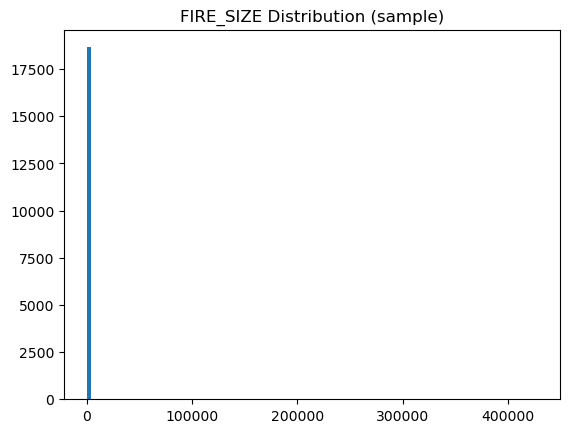

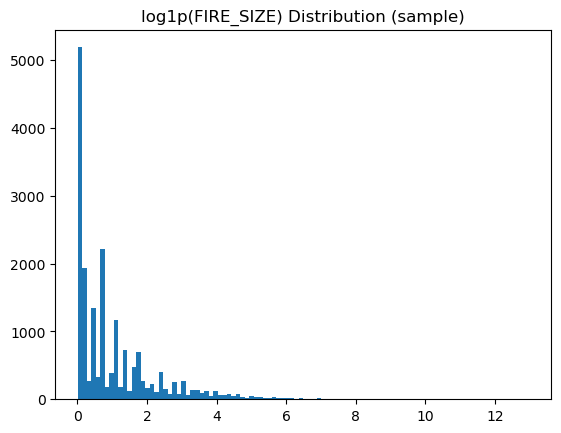

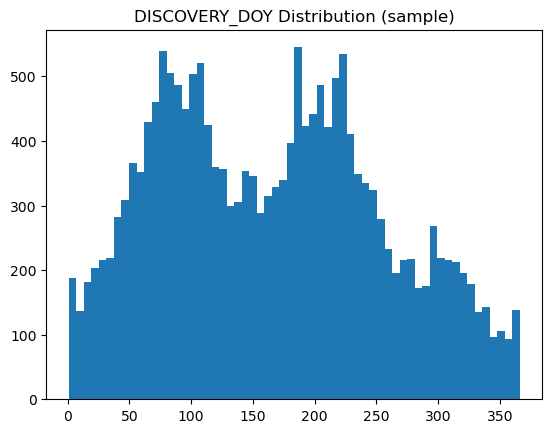

[EDA] 완료


In [11]:
conn = sqlite3.connect("wildfiredata.sqlite")
run_eda(conn)
conn.close()

In [12]:
# ================= 전처리 단계 =================
def run_preprocess(conn):
    print("[PRE] 시작")
    table_has_cols(conn, TABLE, KEEP_COLS)

    # 중심점(평균 위경도) 계산
    row = pd.read_sql_query(
        f"SELECT AVG(LATITUDE) AS avg_lat, AVG(LONGITUDE) AS avg_lon FROM {TABLE};", conn
    ).iloc[0]
    lat0, lon0 = float(row["avg_lat"]), float(row["avg_lon"])
    print(f"[PRE] center(lat0,lon0) = {lat0:.6f}, {lon0:.6f}")

    # STATE 매핑 생성 & 저장
    state_map = build_state_mapping(conn, TABLE)
    with open(os.path.join(ENCODER_DIR, "STATE_mapping.json"), "w", encoding="utf-8") as f:
        json.dump(state_map, f, ensure_ascii=False, indent=2)
    print(f"[PRE] STATE mapping saved → {os.path.join(ENCODER_DIR,'STATE_mapping.json')}")

    # 출력 CSV 초기화
    if os.path.exists(OUTPUT_CSV):
        os.remove(OUTPUT_CSV)

    # 총 행수(로그)
    total_rows = int(sql_scalar(conn, f"SELECT COUNT(1) FROM {TABLE};"))
    print(f"[PRE] total rows: {total_rows:,}")

    select_cols = ", ".join(KEEP_COLS)
    sql = f"SELECT {select_cols} FROM {TABLE};"
    reader = pd.read_sql_query(sql, conn, chunksize=CHUNK)

    wrote_header = False
    processed = 0
    state_na_total = 0  # STATE 매핑 실패 누적

    for df in reader:
        # --- STATE 정규화 → 매핑 ---
        state_mapped = apply_state_mapping(df["STATE"], state_map)
        state_na_chunk = int((state_mapped == -1).sum())
        state_na_total += state_na_chunk
        df["STATE"] = state_mapped

        if state_na_chunk > 0:
            ratio = state_na_chunk / len(df) * 100
            print(f"[WARN][STATE] chunk unmapped: {state_na_chunk:,} rows ({ratio:.2f}%)")

        # POLAR_COORDINATE
        df["r_km"] = haversine_km(lat0, lon0, df["LATITUDE"].values, df["LONGITUDE"].values)
        dlat = np.radians(df["LATITUDE"] - lat0)
        dlon = np.radians(df["LONGITUDE"] - lon0)
        df["theta_rad"] = np.arctan2(dlat, dlon)

        # FIRE_DURATION(분)
        disc_dt = combine_dt(df["DISCOVERY_DATE"], df["DISCOVERY_TIME"])
        cont_dt  = combine_dt(df["CONT_DATE"], df["CONT_TIME"])
        fire_dur = (cont_dt - disc_dt).dt.total_seconds() / 60.0
        df["FIRE_DURATION_min"] = np.where(pd.notna(fire_dur), np.clip(fire_dur, 0, None), np.nan)

        # FIRE_SIZE 로그화
        df["FIRE_SIZE_LOG"] = np.log1p(df["FIRE_SIZE"].clip(lower=0))

        # DISCOVERY_DOY → 주기형 변환
        doy = pd.to_numeric(df["DISCOVERY_DOY"], errors="coerce")
        # (설명) 이렇게 하면 1월 1일과 12월 31일이 ‘연속’임을 모델이 인식합니다.
        df["DOY_sin"] = np.sin(2 * np.pi * doy / 365.0)
        df["DOY_cos"] = np.cos(2 * np.pi * doy / 365.0)

        # 원본 코드 컬럼은 숫자형으로 정리(문자 섞임 방지)
        df["STAT_CAUSE_CODE"] = pd.to_numeric(df["STAT_CAUSE_CODE"], errors="coerce").astype("Int64")
        df["OWNER_CODE"]      = pd.to_numeric(df["OWNER_CODE"],      errors="coerce").astype("Int64")

        # 최종 컬럼
        final_cols = [
            "LATITUDE", "LONGITUDE",
            "r_km", "theta_rad",
            "FIRE_SIZE", "FIRE_SIZE_LOG",
            "FIRE_DURATION_min",
            "STAT_CAUSE_CODE", "STATE", "OWNER_CODE",
            "DISCOVERY_DOY", "DOY_sin", "DOY_cos",
            # 원본 날짜/시간 보존(필요 없으면 제거 가능)
            "DISCOVERY_DATE", "DISCOVERY_TIME", "CONT_DATE", "CONT_TIME",
        ]
        df_out = df[final_cols]

        # 저장(append)
        df_out.to_csv(OUTPUT_CSV, index=False, mode="a", header=not wrote_header)
        wrote_header = True
        processed += len(df_out)
        print(f"[PRE] processed {processed:,}/{total_rows:,}")

    # 전체 매핑 실패 비율 보고
    if processed > 0:
        total_ratio = state_na_total / processed * 100
        if state_na_total > 0:
            print(f"[WARN][STATE] total unmapped: {state_na_total:,}/{processed:,} rows ({total_ratio:.2f}%). "
                  f"STATE 원본 값의 공백/소문자/특수문자/영토 코드 여부를 점검하세요.")
        else:
            print("[OK][STATE] unmapped: 0 rows")

    print(f"[OK] Saved → {OUTPUT_CSV}")
    print("[PRE] 완료")


In [13]:
# ================= 엔트리포인트 =================
def main():
    ensure_dirs()
    with sqlite3.connect(DB_PATH) as conn:
        run_preprocess(conn)

if __name__ == "__main__":
    main()

[PRE] 시작
[PRE] center(lat0,lon0) = 36.781213, -95.704942
[PRE] STATE mapping saved → encoders/STATE_mapping.json
[PRE] total rows: 1,880,465
[PRE] processed 100,000/1,880,465
[PRE] processed 200,000/1,880,465
[PRE] processed 300,000/1,880,465
[PRE] processed 400,000/1,880,465
[PRE] processed 500,000/1,880,465
[PRE] processed 600,000/1,880,465
[PRE] processed 700,000/1,880,465
[PRE] processed 800,000/1,880,465
[PRE] processed 900,000/1,880,465
[PRE] processed 1,000,000/1,880,465
[PRE] processed 1,100,000/1,880,465
[PRE] processed 1,200,000/1,880,465
[PRE] processed 1,300,000/1,880,465
[PRE] processed 1,400,000/1,880,465
[PRE] processed 1,500,000/1,880,465
[PRE] processed 1,600,000/1,880,465
[PRE] processed 1,700,000/1,880,465
[PRE] processed 1,800,000/1,880,465
[PRE] processed 1,880,465/1,880,465
[OK][STATE] unmapped: 0 rows
[OK] Saved → Fires_Processed_AUG12.csv
[PRE] 완료
